# Setup

In [29]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "true"
from transformers import AutoTokenizer, AutoModel, AutoConfig
import warnings
warnings.simplefilter("ignore", UserWarning)
import tokenizers
import transformers
import torch
import torch.nn as nn
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import seaborn as sns
import json
import pandas as pd
pd.set_option("display.max_colwidth", 4000) # to not cut off text in dataframes
import matplotlib.pyplot as plt
import numpy as np

font = {'size': 14}
plt.rc('font', **font)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


cuda:0
tokenizers.__version__: 0.13.1
transformers.__version__: 4.23.1


In [42]:
df = pd.read_csv('data/train.csv.zip')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
df.shape

(3911, 8)

# Try out GPT3 to solve the task

In [30]:
# !pip install openai
import json
import openai
openai.api_key = json.load(open('openai_key.json', 'r'))["OPENAI_API_KEY"]

In [31]:
for model in openai.Model.list()["data"][:10]:
    print(model["id"])

curie-similarity
code-search-babbage-text-001
babbage-search-query
text-davinci-001
davinci-search-query
text-search-babbage-query-001
text-search-curie-query-001
davinci-instruct-beta
text-curie-001
code-search-babbage-code-001


From https://beta.openai.com/docs/models/overview and https://openai.com/api/pricing/
- text-davinci-002: Most capable, max 4096 tokens, training data up to Jun 2021 (\$0.02 per 1k tokens)
- text-curie-001: Very capable, faster, lower cost, max 2048 tokens, training data up to Oct 2019 (\$0.002 per 1k tokens)
- text-babbage-001: Capable, very fast, low cost, max 2048 tokens, training data up to Oct 2019 (\$0.0005 per 1k tokens)
- text-ada-001: For simple tasks, fastest, lowest cost, max 2048 tokens, training data up to Oct 2019 (\$0.0004 per 1k tokens)

## Try to teach GPT3 the feedback price task

In [43]:
df["length"] = df["full_text"].apply(lambda x: len(x))

<AxesSubplot:>

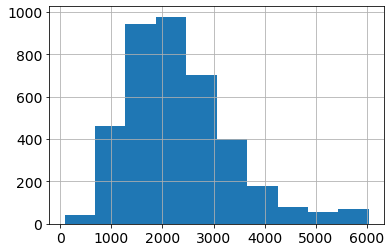

In [44]:
df["length"].hist()

In [45]:
target_col = "grammar"

In [46]:
df[target_col].value_counts()

3.0    994
3.5    880
2.5    855
2.0    544
4.0    447
4.5    134
5.0     29
1.5     20
1.0      8
Name: grammar, dtype: int64

In [47]:
print(df[df[target_col]<=2].shape)
print(df[(df[target_col] > 2.0) & (df[target_col] <= 2.5)].shape)
print(df[(df[target_col] > 2.5) & (df[target_col] <= 3.0)].shape)
print(df[(df[target_col] > 3.0) & (df[target_col] <= 4.0)].shape)
print(df[(df[target_col] > 4.0) & (df[target_col] <= 6.0)].shape)

(572, 9)
(855, 9)
(994, 9)
(1327, 9)
(163, 9)


In [48]:
target_col = "grammar"
text_col = "short_text"
start_seed = 3222
nb_test_examples_rare_categories = 2

# 10 examples from all ranges of scores to test
df_test = pd.concat([
    df[df[target_col] <= 1.5].sample(nb_test_examples_rare_categories, random_state=start_seed+6), 
    df[(df[target_col] > 1.5) & (df[target_col] <= 2.5)].sample(nb_test_examples_rare_categories+1, random_state=start_seed+7), 
    df[(df[target_col] > 2.5) & (df[target_col] <= 3.0)].sample(nb_test_examples_rare_categories+1, random_state=start_seed+8), 
    df[(df[target_col] > 3.0) & (df[target_col] <= 4.0)].sample(nb_test_examples_rare_categories+1, random_state=start_seed+9), 
    df[df[target_col] > 4.0].sample(nb_test_examples_rare_categories, random_state=start_seed+10), 
])
df_test = df_test.sample(len(df_test), random_state=start_seed+11)
print(f"Test shape: {df_test.shape}")

Test shape: (13, 9)


In [49]:
gpt_model_type = "text-curie-001"
nb_train_examples_rare_categories = 1
max_length_train_examples = 750

# gpt_model_type = "text-davinci-002"
# nb_train_examples_rare_categories = 1
# max_length_train_examples = 1500
# nb_train_examples_rare_categories = 2
# max_length_train_examples = 1000

df["short_text"] = df["full_text"].apply(lambda x: x[:max_length_train_examples])
df_test["short_text"] = df_test["full_text"].apply(lambda x: x[:max_length_train_examples])
score_to_label = {1.0: "very bad", 1.5: "very bad", 2.0: "bad", 2.5: "bad", 3.0: "okay", 3.5: "good", 4.0: "good", 4.5: "very good", 5.0: "very good"}
label_to_score = {'very bad': 1.5, 'bad': 2.5, 'okay': 3.0, 'good': 3.5, 'very good': 4.5}

def render_train_example(essay, label):
    return f"""Essay: {essay}\n{target_col.capitalize()}: {score_to_label[label]}"""
    
def create_prompt(train_essays, train_labels, test_essay):
    render_train_examples = "\n\n--\n\n".join(
    [
        render_train_example(essay, label) for essay, label in zip(train_essays, train_labels)
    ])
    return (f"""Decide whether an essay's {target_col} is very bad, bad, okay, good or very good. Also, explain your decision.
    \n\n{render_train_examples}\n\n--\n\nEssay: {test_essay}\n\n{target_col.capitalize()}:""")

# One example from each level of scoring to teach GPT3 how the task should be done + Don't use test examples
df_train = pd.concat([
    df[(~df.index.isin(df_test.index.tolist())) & (df[target_col] <= 1.5)].sample(nb_train_examples_rare_categories, random_state=start_seed), 
    df[(~df.index.isin(df_test.index.tolist())) & (df[target_col] > 1.5) & (df[target_col] <= 2.5)].sample(
        nb_train_examples_rare_categories+1, random_state=start_seed+1), 
    df[(~df.index.isin(df_test.index.tolist())) & (df[target_col] > 2.5) & (df[target_col] <= 3.0)].sample(
        nb_train_examples_rare_categories+1, random_state=start_seed+2), 
    df[(~df.index.isin(df_test.index.tolist())) & (df[target_col] > 3.0) & (df[target_col] <= 4.0)].sample(
        nb_train_examples_rare_categories+1, random_state=start_seed+3), 
    df[(~df.index.isin(df_test.index.tolist())) & (df[target_col] > 4.0)].sample(nb_train_examples_rare_categories, random_state=start_seed+4), 
])
df_train = df_train.sample(len(df_train), random_state=start_seed+5) # shuffle the order
print(f"Train shape: {df_train.shape}")

print(create_prompt(df_train[text_col].tolist(), df_train[target_col].tolist(), df_test[text_col].iloc[0]))

Train shape: (8, 10)
Decide whether an essay's grammar is very bad, bad, okay, good or very good. Also, explain your decision.

Essay: Firstly, Adopting is good for teenagers and may help keep them out of trouble and even breaking the law and others things , adopting may help a lot to teenagers to have a home and education a life better and thats what they need is parent the they support them with everything the they could do for them to help, parents are the best thing the we have in our lives also, teenagers on the street think about why I could have a better life or home it and is so sad for them the they could it have for them seen other teenager having all the good things with their parents, kids on street dont realize the they can get on trouble because they didnt have any education even they dont think because of how they live on the street breaking the laws there a
Grammar: bad

--

Essay: Good actions can be helpful in most ways. Good altered can led to good grades,goal,and re

In [50]:
gpt3_predictions = []
for k in range(1):
    output = openai.Completion.create(
        model=gpt_model_type, 
        prompt=create_prompt(df_train[text_col].tolist(), df_train[target_col].tolist(), df_test[text_col].iloc[k]), 
        max_tokens=100
    )
    gpt3_predictions.append(output["choices"][0]["text"])
    print(output["choices"][0]["text"])

 good


In [27]:
gpt3_predictions = []
for k in range(len(df_test)):
    output = openai.Completion.create(
        model=gpt_model_type, 
        prompt=create_prompt(df_train[text_col].tolist(), df_train[target_col].tolist(), df_test[text_col].iloc[k]), 
        max_tokens=6
    )
    gpt3_predictions.append(output["choices"][0]["text"])
    print(output["choices"][0]["text"])

# i = 0
# for idx, row in df_test.iterrows():
#     print(f"{target_col} Prediction is {label_to_score[gpt3_predictions[i].lower().strip()]}, Truth is {row[target_col]}")
#     print("#"*200)
#     print(row["full_text"])
#     print("#"*200)
#     print("#"*200)
#     i += 1

 good
 bad


very bad
 bad
 bad
 bad
 good
 good
 bad
 bad


very bad
 good
 bad


In [28]:
df_test[f"gpt3_{target_col}"] = [label_to_score[k.lower().strip()] for k in gpt3_predictions] #gpt3_predictions
df_test[f"absolute_error_{target_col}"] = df_test.apply(lambda row: abs(row[f"gpt3_{target_col}"] - row[target_col]), axis=1)
print(f'{target_col}: avg. absolute error: {np.mean(df_test[f"absolute_error_{target_col}"]):.2f} +/- {np.std(df_test[f"absolute_error_{target_col}"]):.2f}')

df_test[[f"gpt3_{target_col}", target_col, f"absolute_error_{target_col}"]]

grammar: avg. absolute error: 1.08 +/- 0.73


,gpt3_grammar,grammar,absolute_error_grammar
807,3.5,3.5,0.0
3426,2.5,4.5,2.0
3192,1.5,3.5,2.0
699,2.5,3.5,1.0
1357,2.5,1.5,1.0
1527,2.5,3.0,0.5
3910,3.5,3.0,0.5
1937,3.5,1.5,2.0
2845,2.5,3.0,0.5
2336,2.5,2.5,0.0


In [21]:
df_test[["gpt3_grammar", "grammar"]].corr()

,gpt3_grammar,grammar
gpt3_grammar,1.000000,0.619356
grammar,0.619356,1.000000


In [ ]:
# EXP1
# target_col = "grammar"
# text_col = "short_text"
# start_seed = 3222
# nb_train_examples_rare_categories = 1
# max_length_train_examples = 1500
# nb_test_examples_rare_categories = 2
## grammar: avg. absolute error: 0.62 +/- 0.68

# EXP2
# max_length_train_examples = 1000
# nb_train_examples_rare_categories = 2
#grammar: avg. absolute error: 0.58 +/- 0.67

# EXP3
# gpt_model_type = "text-curie-001"
# nb_train_examples_rare_categories = 1
# max_length_train_examples = 750
# grammar: avg. absolute error: 1.08 +/- 0.73

## Play around with some prompts

In [59]:
# API: https://beta.openai.com/docs/api-reference/completions/create?lang=python
output = openai.Completion.create(
# ID of the model to use, Required!
  model="text-davinci-002",
# The prompt(s) to generate completions for, encoded as a string, array of strings, array of tokens, or array of token arrays.
# Note that <|endoftext|> is the document separator that the model sees during training, so if a prompt is not specified the 
    # model will generate as if from the beginning of a new document.
  prompt="Say this is a test",
# The maximum number of tokens to generate in the completion.
# The token count of your prompt plus max_tokens cannot exceed the model's context length. 
# Most models have a context length of 2048 tokens (except for the newest models, which support 4096).
  max_tokens=6, 
# What sampling temperature to use. Higher values means the model will take more risks. Try 0.9 for more creative applications, 
    # and 0 (argmax sampling) for ones with a well-defined answer.
# We generally recommend altering this or top_p but not both. Defaults to 1
  temperature=0
# top_p = 1 --> nucleus sampling,  where the model considers the results of the tokens with top_p probability mass. So 0.1 means 
    # only the tokens comprising the top 10% probability mass are considered.
# We generally recommend altering this or temperature but not both.
# n, integer, Optional, Defaults to 1 --> How many completions to generate for each prompt. 
# Note: Because this parameter generates many completions, it can quickly consume your token quota. Use carefully and ensure that you 
    # have reasonable settings for max_tokens and stop.
# stream --> stream back partial progress
# logprobs --> Include the log probs on the 'logprobs' most likely tokens, max is 5
# echo --> echo back the prompt + completion
# stop --> Up to 4 sequences where the API will stop generating further tokens. The returned text will not contain the stop sequence.
# presence_penalty, number, Optional, Defaults to 0 --> Number between -2.0 and 2.0. Positive values penalize new tokens based on whether 
    # they appear in the text so far, increasing the model's likelihood to talk about new topics.
# frequency_penalty, number, Optional, Defaults to 0 --> Number between -2.0 and 2.0. Positive values penalize new tokens based on their 
    # existing frequency in the text so far, 
    # decreasing the model's likelihood to repeat the same line verbatim.
# Generates best_of completions server-side and returns the "best" (the one with the highest log probability per token). Results cannot be streamed. 
    # When used with n, best_of controls the number of candidate completions and n specifies how many to return – best_of must be greater than n.
    # Note: Because this parameter generates many completions, it can quickly consume your token quota. Use carefully and ensure that you have 
    # reasonable settings for max_tokens and stop.
# logit_bias, map, Optional, Defaults to null --> Modify the likelihood of specified tokens appearing in the completion. Accepts a json object that maps tokens 
    # (specified by their token ID in the GPT tokenizer) to an associated bias value from -100 to 100. You can use this tokenizer tool 
    # (which works for both GPT-2 and GPT-3) to convert text to token IDs. 
    # Mathematically, the bias is added to the logits generated by the model prior to sampling. The exact effect will vary per model, 
    # but values between -1 and 1 should decrease or increase likelihood of selection; 
    # values like -100 or 100 should result in a ban or exclusive selection of the relevant token. As an example, you can pass {"50256": -100} 
    # to prevent the <|endoftext|> token from being generated.
# user, string, Optional --> A unique identifier representing your end-user, which will help OpenAI to monitor and detect abuse.
)

In [1]:
prompt = """🛰️ I'm leading the machine learning team at Cloud to Street to build cutting edge Deep Learning models for detecting flood water on satellite imagery.

🏆 All-time highest rank on Kaggle: #58 worldwide of over 100,000 (https://www.kaggle.com/voltaire).

🥇 I scored 1st place in the Open AI Tanzania Challenge for segmentation of building footprints.

 🌏 Beyond my career, I’m passionate about finding (and funding) the most effective charities in the world. I’m part of an international
 community of people who’ve pledged at least 10% of their income over the course of their careers. The Giving What We Can community 
 has over 7,000 members and has pledged in excess of $2.5 billion to the world’s most effective charities. If you’re interested in 
 learning more about the Pledge or if you have any questions, do not hesitate to reach out to me anytime to chat about it.
 """

In [97]:
output = openai.Completion.create(model="text-davinci-002", prompt=prompt, max_tokens=100)

In [98]:
print(output["choices"][0]["text"])


Details


- I am a Machine Learning Engineer with over 7 years of hands on experience. Effortlessly solve challenging problems made easier via the right ML models! I am also an instructor at lambda school where i train students on the deeper aspects of data science.
- I made my mark with my participation on Kaggle the world's largest data science community with over 2MM members classifying satellite images into 40 different classes.
- The aim isto classification of land use, land


In [99]:
output = openai.Completion.create(model="text-davinci-002", prompt=prompt, max_tokens=100, temperature=0)

In [100]:
print(output["choices"][0]["text"])



## 📚 Education

**Master of Science in Data Science**

University of California, Berkeley

**Bachelor of Science in Mathematics**

University of California, Berkeley

## 📝 Publications

**Detecting Flood Water on Satellite Imagery**

https://towardsdatascience.com/detecting-flood-water-on-satellite-imagery-with-deep-learning-e0a8


In [3]:
prompt = "Brainstorm some ideas combining BioTech and Github:"

In [6]:
output = openai.Completion.create(model="text-davinci-002", prompt=prompt, max_tokens=200, temperature=1)

In [5]:
print(output["choices"][0]["text"])



1. Create a Github repository for open-source software related to biotech research.
2. Use Github to manage and share data related to biotech experiments.
3. Use Github to develop and share protocols for biotech experiments.
4. Collaborate on biotech research using Github issues and pull requests.
5. Share results of biotech experiments on Github.
6. Use Github to manage references for biotech research.
7. Develop a biotech research platform using Github Pages.
8.


In [7]:
print(output["choices"][0]["text"])



1. A BioTech company could use Github to manage and share their code repositories with collaborators.

2. A BioTech company could use Github to create an online database of their research findings.

3. A BioTech company could use Github to share information about upcoming conferences and events.

4. A BioTech company could use Github to post job openings and attract top talent.


In [8]:
prompt = "Brainstorm some ideas combining BioTech and software development or version control:"

In [9]:
output = openai.Completion.create(model="text-davinci-002", prompt=prompt, max_tokens=200, temperature=1)

In [10]:
print(output["choices"][0]["text"])



-A system that tracks and manages different versions of software code used in bioinformatics algorithms
-A tool that uses machine learning to develop more efficient bioinformatics software
-A software development platform specifically for developing bioinformatics applications
-A version control system for tracking and managing different versions of DNA sequences
-A tool that uses artificial intelligence to predict which software changes will improve the performance of bioinformatics algorithms


In [11]:
output = openai.Completion.create(model="text-davinci-002", prompt=prompt, max_tokens=200, temperature=1)
print(output["choices"][0]["text"])



-A software development company that specializes in creating applications for the biotech industry
-A version control system for biotech software development projects
-A software development company that specializes in creating applications for the biotech industry
-A web application that allows users to track and predict the success of various biotech drugs in development


In [12]:
prompt = "Tell me a funny story of how Alex successfully founded a company that does something nobody thought was needed:"
output = openai.Completion.create(model="text-davinci-002", prompt=prompt, max_tokens=200, temperature=1)

print(output["choices"][0]["text"])

In [32]:
prompt = "Tell me a funny story of how Nicola negotiated on her starting date and travel reimbursements on her new job as a product manager at a startup in Heidelberg:"
output = openai.Completion.create(model="text-davinci-002", prompt=prompt, max_tokens=200, temperature=1)
print(output["choices"][0]["text"])



Nicola had just landed her dream job as a product manager at a startup in Heidelberg. She was thrilled to be starting her new role and was eager to get to work. However, when she went to negotiation her start date and travel reimbursements, she realized that the company was very tight on budget. Nicola had to get creative in her negotiation and ended up striking a deal where she would start work two weeks later than originally planned, but in exchange, the company would reimburse her for her travel costs. She was happy with the compromise and excited to start her new job.


In [33]:
output = openai.Completion.create(model="text-davinci-002", prompt=prompt, max_tokens=200, temperature=1)
print(output["choices"][0]["text"])



 Nicola was very excited to start her new job as a product manager at a startup in Heidelberg. However, she was not happy with the company's offer of start date and travel reimbursement. She decided to negotiate with the company and was successful in getting what she wanted.


In [41]:
prompt = "Tell me a very funny story of Nicola and Jonathan in Heidelberg:"
output = openai.Completion.create(model="text-davinci-002", prompt=prompt, max_tokens=200, temperature=1)
print(output["choices"][0]["text"])



One day, Nicola and Jonathan were walking around Heidelberg when they saw a very imposing castle on a hill. They decided to explore it and, after a long climb, they finally reached the top. As they were admiring the view, they heard someone coming up the stairs behind them. They turned around to see a very large, angry-looking guard.

The guard shouted at them in German, and Nicola and Jonathan had no idea what he was saying. But the tone of his voice was very clear: they were not welcome there. They quickly ran back down the stairs and didn't look back until they were well away from the castle.

It was only then that they realized they had accidentally trespassed into a restricted area. They must have been trespassing for quite some time, because the guard had been coming up the stairs to get them for a while. They must have looked completely ridiculous, running away from the castle like that. But it was all very
